## Approach

* This is a simplied version of YOLO. The input image is 512x512. YOLO was intended to train on images which all contained at least one object, most multiple objects. The architecture and loss functions have been adapted for this case, where not every image contains an object and there are at most 4 ROIs per image. 
* Since the maximum number of ROIs in each image is 4 we decided to use a 2x2 grid to simplify the network. In the case where multiple ROIs occur in the same cell we combine the ROIs into a single ROI by expanding the box to include both. Each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The classification loss has been removed.
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this doesn't really make any sense and ends up driving the confidence down to the IOU. We replace this by an IOU loss which subtracts the IOU for that cell from 1.

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* There are two dilated convolutions at the end of the network to provide context.
* The dilated convolutions are followed by two strided convolutions which downsize to 2x2.
* Finally there are a series of 1x1 convolutions which output a 2x2x5 tensor.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients, which had been a problem.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.
* v10 - using 2x2 grid as output
* v12 - changing layout of model slightly - replaced final pools with convs with strides; reduced number of params; ensure that there is at least one positive image per batch.
* v13 - tweaking architecture slightly.
* v17 - trying 4x4 grid with better labels

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q imgaug 
!pip3 install -q kaggle
!pip3 install -q tqdm 

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    return 1 / (1 + np.exp(-y))    

# adjust contrast of image
def change_contrast(img, contrast_factor):
    mean = np.mean(img)
    img = (img - mean) * contrast_factor + mean
    return img

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [6]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [7]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
    !kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 34.3kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 79.4MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 35.9MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 92.1MB/s]
 98% 124M/126M [00:02<00:00, 47.5MB/s]
100% 126M/126M [00:02<00:00, 61.8MB/s]
100% 3.16G/3.17G [00:47<00:00, 80.7MB/s]
100% 3.17G/3.17G [00:47<00:00, 71.0MB/s]


In [8]:
# unzipping takes a few minutes
if not os.path.exists("./stage_1_train_labels.csv"):
    print("Unzipping...")
    !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
    !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
    !unzip -q -o stage_1_train_labels.csv.zip

Unzipping...


# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [9]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [10]:
!gsutil cp gs://{bucket_name}/yolo_labels_centered_4x4_10a.p ./yolo_labels_centered_4x4_10a.p

Copying gs://pneumonia/yolo_labels_centered_4x4_10a.p...
| [1 files][ 17.5 MiB/ 17.5 MiB]                                                
Operation completed over 1 objects/17.5 MiB.                                     


In [0]:
with open('yolo_labels_centered_4x4_10a.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [12]:
random.seed(24)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.15)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 21832
n valid samples 3852


In [0]:
positive_images = []

for filename in pneumonia_locations:
    label = pneumonia_locations[filename][...,0]
    if np.max(label) > 1e-6:
        if filename + ".dcm" in train_filenames:
            positive_images.append(filename + ".dcm")

 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [0]:
BATCH_SIZE = 14
IMAGE_SIZE = 512
GRID_SIZE = 4
CELL_SIZE = 1024 / GRID_SIZE
CHECKPOINT_PATH = "yolo17_2_512.h5"

In [15]:
!gsutil cp gs://{bucket_name}/{CHECKPOINT_PATH} ./{CHECKPOINT_PATH}

Copying gs://pneumonia/yolo17_2_512.h5...
/ [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


In [0]:
# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def augment_imgs(self, img, confs, boxes):
        # flip the image half the time
        if random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = (confs != 0)
            
            # flip
            boxes[mask, 0] = (1 - boxes[mask,0])
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=1)   
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=1)            
            
        ## small random shifts
        h_offset = np.random.randint(low=0, high=5)
        v_offset = np.random.randint(low=0, high=5)

        # crop the images
        img = img[v_offset:,h_offset:]
           
        ## adjust contrast half the time
        if random.random() > 0.5:  
            # generate a random contrast adjustment
            contrast_factor = np.random.normal(loc=1.0, scale=0.10)
            
            # put some limits on the contrast
            contrast_factor = np.minimum(contrast_factor, 1.25)
            contrast_factor = np.maximum(contrast_factor, 0.75)
            
            # adjust the image
            img = change_contrast(img, contrast_factor)
            
        return img, confs, boxes
            
            
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        # round the confidences since some are 0.99 or maybe even 1e-6
        confs = np.round(label[:,:,0])
        boxes = label[:,:,1:]
        
        ## augment the data with flips, small shifts and contrast adjustment
        if self.augment:
            img, confs, boxes = self.augment_imgs(img, confs, boxes)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # scale and center the image
        img = (img - np.mean(img)) / np.max(img)
        
        boxes = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            # make sure there is at least one positive image in the batch
            pos = np.max(bboxes[:,:,:,0])
            if pos < 1:
                # pick a random positive image
                filename = np.random.choice(positive_images)
                img, label = self.__load__(filename)
                
                # add the positive image to our batch
                imgs[-1] = img
                bboxes[-1] = label
                
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
# train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)

# counter = 0
# for imgs, labels in train_gen:
#     for label in labels:
#         for i in range(4):
#             for j in range(4):
#                 if label[i,j,0] == 1:
#                     if label[i,j,4] ==  0.001:
#                         print("Error!")
#     counter += 1
#     if counter > 15:
#         break

# Network

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.MaxPool2D(2)(x)
    x_2 = keras.layers.AveragePooling2D(2)(x)
    x = keras.layers.concatenate([x_1, x_2])
    x = keras.layers.Conv2D(channels, 1, padding="same", use_bias=False)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
#     x = keras.layers.add([x, inputs])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # downsample to 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
#     x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
#     x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        
        x = create_downsample(channels, x)
        channels = channels * 2
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
#     x = create_downsample(channels, x)
    x_2 = x
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 15x15x512
    x = keras.layers.Conv2D(channels, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, (3,3), padding='same', strides=(1,1), activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # downsample to 8x8 with stride 2
    x = keras.layers.Conv2D(512, (5,5), padding='same', strides=(4,4), activation=None, name="downsample_1", kernel_regularizer=keras.regularizers.l2(l=0.002))(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.10)(x)
    
    # bounding box branch
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.20)(b)
    
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.005))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    
    boxes = keras.layers.Conv2D(5, (1,1), padding='same', activation="linear")(b)
#     boxes = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=boxes)
    
    return model

# Train network


In [0]:
# after each epoch run our function to calculate the actual IOU for half of the validation images. 
# I was not able to figure out how to implement this in tensorflow since I don't think we can iterate
# through tensors. So we do it as a callback instead. Hopefully this will approximate the actual IOU score.
class Calc_IOU_CB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        valid_gen2 = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=IMAGE_SIZE, shuffle=True, predict=False)
        ious = []
        tps = 0
        fps = 0
        fns = 0
        
        counter = 0
        for imgs, labels in valid_gen2:
            preds = self.model.predict(imgs)
            
            # calculate the IOU
            iou = overlap_iou2(labels, preds)
            ious.append(iou)
            
            # calculate the precision and recall
            tp, fp, fn = calc_tps(labels, preds)
            
            tps += tp
            fps += fp
            fns += fn
            
            counter += BATCH_SIZE
            
            if counter > 900:
                break
        
        prec = tps / (tps + fps)
        recall = tps / (tps + fns)
        print("Epoch", epoch, ": Mean IOU:", np.mean(ious), "Precision:", prec, "Recall:", recall)
        
        return
      
# count the true pos, false pos and false negatives so we can calculate precision and recall
def calc_tps(y_true, y_pred):
    true_confs = np.round(y_true[...,0])
    pred_confs = np.round(sigmoid(y_pred[...,0]))
    
    tps = np.sum((pred_confs == 1) & (true_confs == 1))
    fps = np.sum((pred_confs == 1) & (true_confs != 1))
    fns = np.sum((pred_confs != 1) & (true_confs == 1))
    
    return tps, fps, fns      

In [41]:


def binary_accuracy(y_true, y_pred):
    # apply sigmoid to our predictions
    y_pred = tf.sigmoid(y_pred)
    # round both since our negative truths are 1e-16 instead of 0
    y_true = tf.round(tf.reshape(y_true, [-1, 5]))
    y_pred = tf.round(tf.reshape(y_pred, [-1, 5]))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[:,0], y_pred[:,0]), dtype=tf.float32))
    return acc

def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    y_pred = tf.sigmoid(y_pred)
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # uncenter the data - make sure the numbers are positive
    x11 = x11 * CELL_SIZE
    x21 = x21 * CELL_SIZE
    y11 = y11 * CELL_SIZE
    y21 = y21 * CELL_SIZE
    
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # is there either a box predicted here or a box actually here?
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # get the far corners of the boxes
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    iou = tf.maximum(inter_area/(union + 1e-6), 0)
    
    # apply the mask
    iou = tf.boolean_mask(iou, mask)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)

def overlap_iou2(y_true, y_pred):
    """
    Args:
        y_true and y_pred - arrays of boxes containing center points, h and w of boxes
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Average IOU over boxes
    """
    OVERLAP = 0.3
    
    # apply the sigmoid
    y_pred = sigmoid(y_pred)
    
    ious = []
    
    # loop over both sets of boxes
    for truth, pred in zip(y_true, y_pred):
        # get true area
        true_area = 0
        true_boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = truth[i,j,:]
                # if we have an ROI
                if c == 1:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    true_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    true_boxes.append([x, y, x+w, y+h])
                    
        pred_area = 0
        pred_boxes = []
        # get the predicted area
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = pred[i,j,:]
                # if we have an ROI
                if c > 0.5:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    pred_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    pred_boxes.append([x, y, x+w, y+h])
            
        intersect_area = 0
        
        # non-max suppression?
        pred_boxes = non_max_suppression_fast(np.array(pred_boxes), OVERLAP)
        
        # get the intersection
        for pred_box in pred_boxes:
            x1_p, y1_p, x2_p, y2_p = pred_box
            
            for true_box in true_boxes:
                x1_t, y1_t, x2_t, y2_t = true_box
                
                # if the boxes overlap at all
                if (x1_p >= x1_t and y1_p >= y1_t) or (x1_p <= x1_t and y1_p <= y1_t):
                    # get the intersection corners
                    x1_i = np.maximum(x1_p, x1_t)
                    y1_i = np.maximum(y1_p, y1_t)
                    x2_i = np.minimum(x2_p, x2_t)
                    y2_i = np.minimum(y2_p, y2_t)
                    
                    # get area of intersect
                    i_w, i_h = x2_i - x1_i, y2_i - y1_i

                    # trap for negative numbers
                    i_w = np.maximum(i_w, 0)
                    i_h = np.maximum(i_h, 0)

                    intersection = i_w * i_h
                    intersect_area += intersection

        union = true_area + pred_area - intersect_area
        
        iou = intersect_area / (union + 1e-16)
        
        # only count the IOU if there are truths or predictions
        if len(true_boxes) or len(pred_boxes):
            ious.append(iou)
    
    iou_area = np.mean(ious)
    return iou_area
                    
def loss_fn(y_true, y_pred):
    # get the iou loss
    iou_loss = iou_loss_fn(y_true, y_pred)
    
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (1.5 * xe_loss) + (box_loss * 2.0) + (iou_loss * 1.0)

# only apply mse to layers with high confidence that there is an ROI or if there actually is an ROI
def adj_mse(y_true, y_pred):
    # coefficients
    lam_coord = 5
    lam_noobj = 0.5
    
    y_pred = tf.sigmoid(y_pred)
        
    # flatten the inputs
    y_true = tf.reshape(y_true, (-1, 5))
    y_pred = tf.reshape(y_pred, (-1, 5))

    # separate the confidence from the boxes
    conf_true, x_true, y_true, w_true, h_true = tf.split(y_true, 5, axis=1)
    conf_pred, x_pred, y_pred, w_pred, h_pred = tf.split(y_pred, 5, axis=1)

    # center squared error
    center_se = tf.square(x_true - y_pred) + tf.square(y_true - y_pred)
    size_se =  tf.square(tf.sqrt(w_true) - tf.sqrt(w_pred)) + tf.square(tf.sqrt(h_true) - tf.sqrt(h_pred))
    
    box_se = center_se + size_se
    
    # only get loss for boxes which are actually positive
    mask = tf.equal(conf_true, 1)
    box_se = tf.boolean_mask(box_se, mask)
    
    # weight the loss higher
    box_se = tf.multiply(box_se, 5.0)
    
    loss = tf.reduce_sum(box_se)
    
    return loss
    
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = y_true[...,0]
    conf_pred = tf.sigmoid(y_pred[...,0])
    
    weight = 7.0
    weights = tf.multiply(y_true[...,0], weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def objectness_loss_fn(y_true, y_pred):
    y_pred = tf.sigmoid(y_pred)
    
    # pred box conf
    pred_box_conf = y_pred[...,0]
    
    # separate the x, y from the w, h
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    true_box_conf = iou_scores * y_true[..., 0]
    
    conf_mask  = tf.zeros_like(iou_scores)
    conf_mask = conf_mask + tf.cast((iou_scores < 0.6), dtype=tf.float32) * (1 - y_true[...,0])
    conf_mask = conf_mask + y_true[..., 0] * 5.0
    
    nb_conf_box  = tf.reduce_sum(tf.cast((conf_mask > 0.0), dtype=tf.float32)) 
    
    loss_conf  =  tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    
    return tf.reduce_sum(loss_conf)

def iou_loss_fn(y_true, y_pred):
    # apply sigmoid to predictions
    y_pred = tf.sigmoid(y_pred)
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    # multiple the IOU by the confidence for a more useful loss function
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16) * y_pred[...,0]
    
    # only use the IOU from boxes which actually have ROIs
    mask = tf.equal(y_true[...,0], 1)
    use_iou = tf.boolean_mask(1 - iou_scores, mask)
    
    return tf.reduce_sum(use_iou)
    
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-7, clipnorm=2.0, clipvalue=0.75)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, overlap_iou, adj_mse, binary_cross_entropy])

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.003
    epochs_drop = 10
    drop = 0.85
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
calc_iou = Calc_IOU_CB()

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 256, 256, 24) 216         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 256, 256, 24) 96          conv2d_120[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_140 (LeakyReLU)     (None, 256, 256, 24) 0           batch_normalization_140[0][0]    
__________________________________________________________________________________________________
conv2d_121

In [0]:
  model.load_weights(CHECKPOINT_PATH)

In [21]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=20, shuffle=True, verbose=1, initial_epoch=0)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 175.6872 - binary_accuracy: 0.8094 - overlap_iou: nan - adj_mse: 13.5090 - binary_cross_entropy: 37.9756
Epoch 00001: saving model to yolo17_2_512.h5
1559/1559 [==============================] - 1183s 759ms/step - loss: 175.7001 - binary_accuracy: 0.8094 - overlap_iou: nan - adj_mse: 13.5139 - binary_cross_entropy: 37.9734 - val_loss: 155.3596 - val_binary_accuracy: 0.8468 - val_overlap_iou: 3.2943e-04 - val_adj_mse: 15.9609 - val_binary_cross_entropy: 26.2663
Epoch 2/20
1558/1559 [============================>.] - ETA: 0s - loss: 102.7778 - binary_accuracy: 0.8537 - overlap_iou: nan - adj_mse: 9.2517 - binary_cross_entropy: 27.0908
Epoch 00002: saving model to yolo17_2_512.h5
1559/1559 [==============================] - 1143s 733ms/step - loss: 102.7668 - binary_accuracy: 0.8537 - overlap_iou: nan - adj_mse: 9.2524 - binary_cross_entropy: 27.0863 - val_loss: 75.7849 - val_binary_accuracy: 0.7776 - val_overlap_iou: 0.0402 - v

In [30]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=30, shuffle=True, verbose=1, initial_epoch=20)

Epoch 21/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 52.7576 - binary_accuracy: 0.9241 - overlap_iou: 0.1332 - adj_mse: 5.3632 - binary_cross_entropy: 16.5252
Epoch 00021: saving model to yolo17_2_512.h5
Epoch 20 : Mean IOU: 0.03230935316778731
1559/1559 [==============================] - 1283s 823ms/step - loss: 52.7433 - binary_accuracy: 0.9241 - overlap_iou: 0.1332 - adj_mse: 5.3603 - binary_cross_entropy: 16.5249 - val_loss: 53.0132 - val_binary_accuracy: 0.8942 - val_overlap_iou: 0.0993 - val_adj_mse: 5.3563 - val_binary_cross_entropy: 16.8381
Epoch 22/30
1558/1559 [============================>.] - ETA: 0s - loss: 52.4142 - binary_accuracy: 0.9198 - overlap_iou: 0.1280 - adj_mse: 5.3829 - binary_cross_entropy: 16.2264
Epoch 00022: saving model to yolo17_2_512.h5
Epoch 21 : Mean IOU: 0.0270861750154066
1559/1559 [==============================] - 1257s 806ms/step - loss: 52.4388 - binary_accuracy: 0.9198 - overlap_iou: 0.1279 - adj_mse: 5.3844 - binary_cross_entropy: 16.23

In [24]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=40, shuffle=True, verbose=1, initial_epoch=30)

Epoch 31/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 48.8045 - binary_accuracy: 0.9243 - overlap_iou: 0.1352 - adj_mse: 5.3351 - binary_cross_entropy: 16.1129
Epoch 00031: saving model to yolo17_2_512.h5
Epoch 30 : Mean IOU: 0.040503350100430734
1559/1559 [==============================] - 1284s 824ms/step - loss: 48.8167 - binary_accuracy: 0.9243 - overlap_iou: 0.1354 - adj_mse: 5.3363 - binary_cross_entropy: 16.1177 - val_loss: 46.2730 - val_binary_accuracy: 0.9329 - val_overlap_iou: 0.1449 - val_adj_mse: 5.2353 - val_binary_cross_entropy: 14.7851
Epoch 32/40
1558/1559 [============================>.] - ETA: 0s - loss: 48.5956 - binary_accuracy: 0.9234 - overlap_iou: 0.1340 - adj_mse: 5.3036 - binary_cross_entropy: 16.0169
Epoch 00032: saving model to yolo17_2_512.h5
Epoch 31 : Mean IOU: 0.024181840649967975
1559/1559 [==============================] - 1242s 797ms/step - loss: 48.5725 - binary_accuracy: 0.9234 - overlap_iou: 0.1340 - adj_mse: 5.3003 - binary_cross_entropy: 16

In [33]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=50, shuffle=True, verbose=1, initial_epoch=40)

Epoch 41/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 45.9717 - binary_accuracy: 0.9277 - overlap_iou: 0.1378 - adj_mse: 5.3101 - binary_cross_entropy: 16.5246
Epoch 00041: saving model to yolo17_2_512.h5
Epoch 40 : Mean IOU: 0.03344628878664037
1559/1559 [==============================] - 1297s 832ms/step - loss: 45.9788 - binary_accuracy: 0.9277 - overlap_iou: 0.1378 - adj_mse: 5.3088 - binary_cross_entropy: 16.5319 - val_loss: 42.1263 - val_binary_accuracy: 0.9294 - val_overlap_iou: 0.1419 - val_adj_mse: 5.1945 - val_binary_cross_entropy: 14.3156
Epoch 42/50
1558/1559 [============================>.] - ETA: 0s - loss: 45.7677 - binary_accuracy: 0.9264 - overlap_iou: 0.1357 - adj_mse: 5.3019 - binary_cross_entropy: 16.3903
Epoch 00042: saving model to yolo17_2_512.h5
Epoch 41 : Mean IOU: 0.04786032742800441
1559/1559 [==============================] - 1261s 809ms/step - loss: 45.7520 - binary_accuracy: 0.9264 - overlap_iou: 0.1358 - adj_mse: 5.3008 - binary_cross_entropy: 16.3

In [41]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=60, shuffle=True, verbose=1, initial_epoch=50)

Epoch 51/60


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 45.6300 - binary_accuracy: 0.9276 - overlap_iou: 0.1369 - adj_mse: 5.3256 - binary_cross_entropy: 16.2893
Epoch 00051: saving model to yolo17_2_512.h5
Epoch 50 : Mean IOU: 0.026297018321729516
1559/1559 [==============================] - 1321s 847ms/step - loss: 45.6142 - binary_accuracy: 0.9277 - overlap_iou: 0.1370 - adj_mse: 5.3245 - binary_cross_entropy: 16.2817 - val_loss: 41.4002 - val_binary_accuracy: 0.9123 - val_overlap_iou: 0.1207 - val_adj_mse: 5.2240 - val_binary_cross_entropy: 13.7654
Epoch 52/60
1558/1559 [============================>.] - ETA: 0s - loss: 44.8659 - binary_accuracy: 0.9270 - overlap_iou: 0.1353 - adj_mse: 5.3199 - binary_cross_entropy: 15.7965
Epoch 00052: saving model to yolo17_2_512.h5
Epoch 51 : Mean IOU: 0.03562581780183487
1559/1559 [==============================] - 1273s 816ms/step - loss: 44.8466 - binary_accuracy: 0.9270 - overlap_iou: 0.1353 - adj_mse: 5.3174 - binary_cross_entropy: 15.

In [32]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=75, shuffle=True, verbose=1, initial_epoch=70)

Epoch 71/75


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1558/1559 [============================>.] - ETA: 0s - loss: 37.5997 - binary_accuracy: 0.9389 - overlap_iou: 0.1534 - adj_mse: 5.2265 - binary_cross_entropy: 14.4232
Epoch 00071: saving model to yolo17_2_512.h5
Epoch 70 : Mean IOU: 0.007539410782596916 Precision: 0.05806045340050378 Recall: 0.9275653923541247
1559/1559 [==============================] - 1349s 865ms/step - loss: 37.5856 - binary_accuracy: 0.9389 - overlap_iou: 0.1534 - adj_mse: 5.2241 - binary_cross_entropy: 14.4180 - val_loss: 68.1539 - val_binary_accuracy: 0.5474 - val_overlap_iou: 0.0272 - val_adj_mse: 5.2140 - val_binary_cross_entropy: 35.0524
Epoch 72/75
1558/1559 [============================>.] - ETA: 0s - loss: 37.6555 - binary_accuracy: 0.9375 - overlap_iou: 0.1497 - adj_mse: 5.2743 - binary_cross_entropy: 14.3767
Epoch 00072: saving model to yolo17_2_512.h5
Epoch 71 : Mean IOU: 0.0061113179220970365 Precision: 0.05723231058234189 Recall: 0.9269776876267748
1559/1559 [==============================] - 1301s 83

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=85, shuffle=True, verbose=1, initial_epoch=75)

Epoch 76/85


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 106/1559 [=>............................] - ETA: 21:25 - loss: 41.1182 - binary_accuracy: 0.9366 - overlap_iou: 0.1638 - adj_mse: 6.7007 - binary_cross_entropy: 14.5121

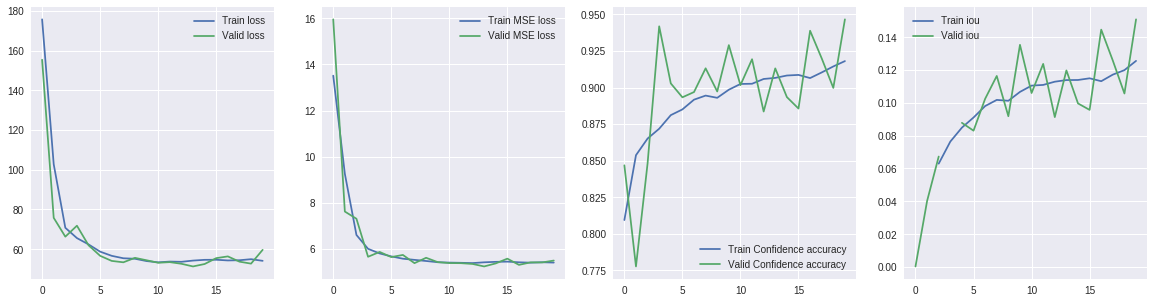

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

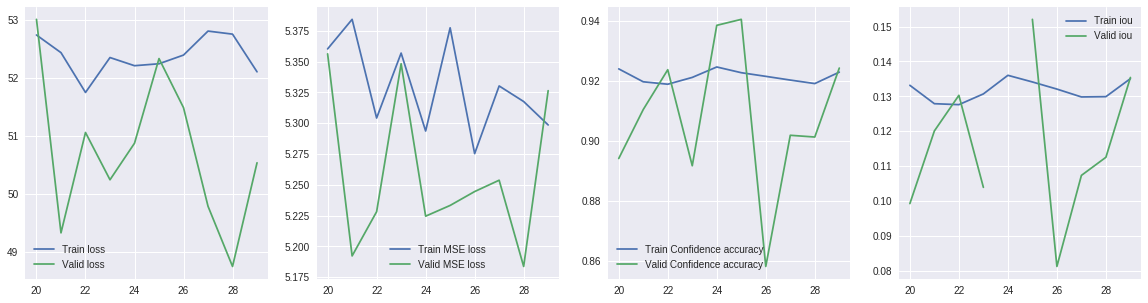

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

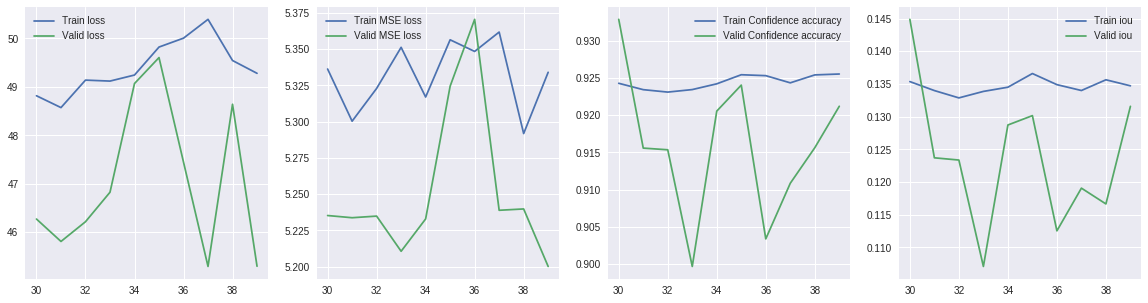

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

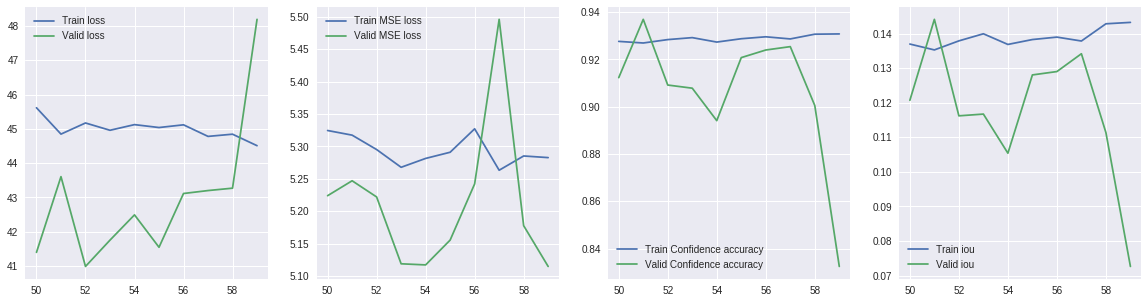

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

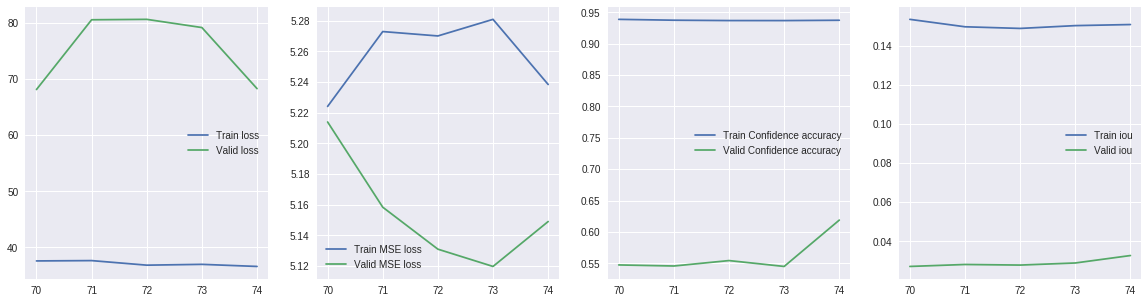

In [33]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

Pred: 0 0 conf: 0.88271683 11 46 206 255
Pred: 0 1 conf: 0.8124009 272 55 204 247
Pred: 0 2 conf: 0.8336696 541 54 203 247
Pred: 1 1 conf: 0.76280767 209 244 223 263
Pred: 1 2 conf: 0.70710653 612 287 233 352
Pred: 1 3 conf: 0.88874084 682 192 246 338
Pred: 2 3 conf: 0.9068285 671 419 238 285
True: 0 Pred: 362686 Intersect: 0
IOU: 0.0


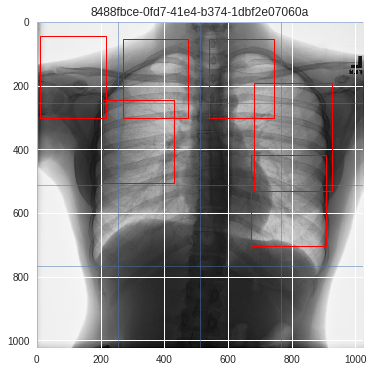

Pred: 0 0 conf: 0.83724576 21 49 205 250
Pred: 0 1 conf: 0.91034883 266 48 205 248
Pred: 0 2 conf: 0.866388 541 53 203 244
True: 0 Pred: 151622 Intersect: 0
IOU: 0.0


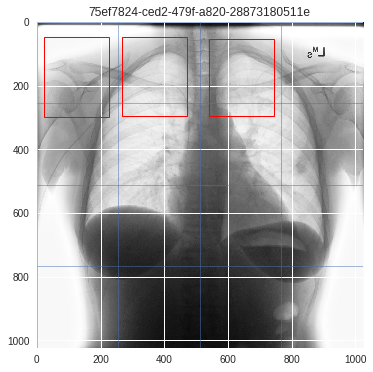

Truth: 1 1 186 266 225 472
Truth: 1 2 505 261 225 482
Truth: 2 1 186 266 225 529
Truth: 2 2 505 261 225 618
Pred: 0 0 conf: 0.8556752 15 48 206 257
Pred: 0 1 conf: 0.8296324 273 52 205 244
Pred: 0 2 conf: 0.94634753 531 44 208 262
Pred: 1 1 conf: 0.8121486 233 224 243 377
Pred: 1 2 conf: 0.99997675 540 241 242 382
Pred: 2 1 conf: 1.0 174 366 245 441
Pred: 2 2 conf: 1.0 483 366 253 466
True: 472725 Pred: 383401 Intersect: 398820
IOU: 0.8721075166280956


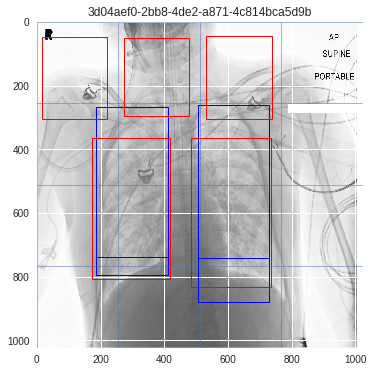

Truth: 2 1 306 573 210 224
Truth: 2 3 689 527 210 258
Pred: 0 0 conf: 0.9695711 11 36 209 293
Pred: 0 1 conf: 0.9914312 269 29 213 298
Pred: 0 2 conf: 0.95763844 534 40 209 281
Pred: 1 1 conf: 0.99502325 232 209 263 436
Pred: 1 2 conf: 0.8297551 614 259 241 388
Pred: 1 3 conf: 0.94763315 672 161 263 421
Pred: 2 1 conf: 0.99999774 286 454 230 336
Pred: 2 2 conf: 0.9435667 585 486 231 336
Pred: 2 3 conf: 0.9999316 657 364 255 373
True: 101220 Pred: 546512 Intersect: 111864
IOU: 0.2087529018336442


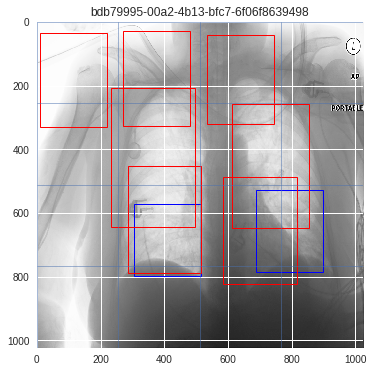

Truth: 2 1 229 475 197 174
Pred: 0 0 conf: 0.9454664 0 36 205 268
Pred: 0 1 conf: 0.8700007 269 55 205 239
Pred: 0 2 conf: 0.80501914 542 52 205 251
Pred: 1 1 conf: 0.99999976 199 192 234 385
Pred: 1 2 conf: 0.9999993 546 247 231 340
Pred: 2 1 conf: 0.9722481 196 426 222 288
Pred: 2 2 conf: 0.8555546 555 468 221 293
Pred: 3 0 conf: 0.7222252 130 808 218 268
True: 34278 Pred: 511133 Intersect: 52980
IOU: 0.10758867739823937


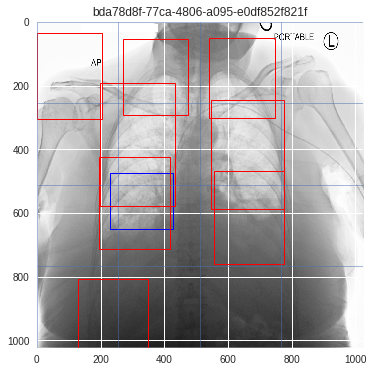

Pred: 0 0 conf: 0.9139581 12 42 207 267
Pred: 0 1 conf: 0.8345253 270 53 205 248
Pred: 0 2 conf: 0.93940955 539 46 206 255
Pred: 2 1 conf: 0.952114 221 469 207 240
True: 0 Pred: 208319 Intersect: 0
IOU: 0.0


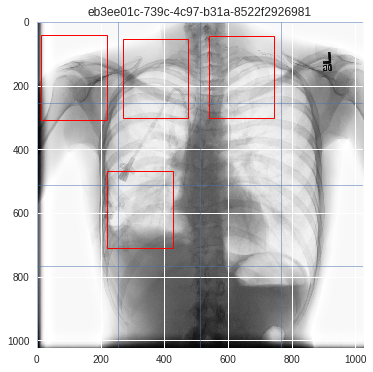

Truth: 1 1 359 303 177 258
Truth: 1 2 672 169 185 367
Truth: 1 3 681 169 185 367
Pred: 0 0 conf: 0.845094 29 52 206 259
Pred: 0 1 conf: 0.99075365 279 34 212 291
Pred: 0 2 conf: 0.8208641 551 52 204 264
Pred: 1 1 conf: 1.0 261 192 233 373
Pred: 1 2 conf: 0.97961193 603 243 237 370
Pred: 1 3 conf: 0.99999917 654 85 263 475
Pred: 2 3 conf: 0.96433663 667 407 250 353
True: 181456 Pred: 353438 Intersect: 218350
IOU: 0.6897935200139955


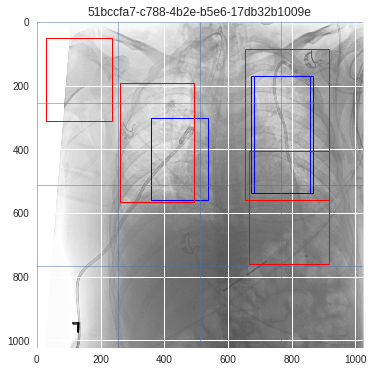

Truth: 2 1 163 672 243 151
Truth: 2 2 544 558 205 185
Pred: 0 0 conf: 0.88388634 22 49 206 255
Pred: 0 1 conf: 0.8577058 281 53 206 251
Pred: 0 2 conf: 0.80438673 542 59 204 236
Pred: 2 1 conf: 0.7496307 259 495 214 272
Pred: 2 2 conf: 0.9999448 562 497 220 293
Pred: 3 0 conf: 0.7287261 130 812 218 273
True: 74618 Pred: 334562 Intersect: 50595
IOU: 0.1410962533286638


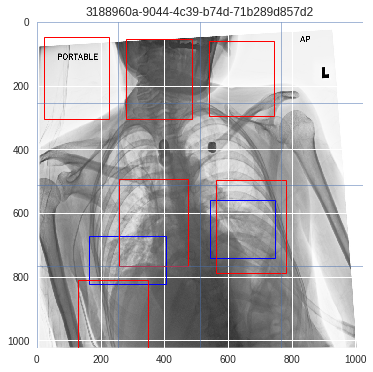

Pred: 0 0 conf: 0.81655943 17 49 205 263
Pred: 0 1 conf: 0.9918582 257 27 213 285
Pred: 0 2 conf: 0.91552955 549 42 209 282
Pred: 1 1 conf: 1.0 180 119 255 507
Pred: 1 2 conf: 1.0 588 208 255 471
Pred: 2 0 conf: 0.7686667 127 527 220 267
Pred: 2 1 conf: 0.9932808 175 395 232 334
Pred: 2 2 conf: 0.9992487 588 439 243 395
True: 0 Pred: 396863 Intersect: 0
IOU: 0.0


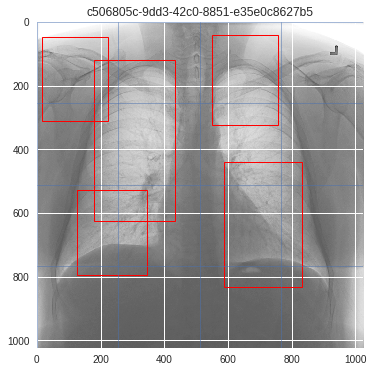

Pred: 0 0 conf: 0.82749104 28 51 206 263
Pred: 0 1 conf: 0.9945363 250 23 213 288
Pred: 0 2 conf: 0.9564545 547 39 209 295
Pred: 1 0 conf: 0.7270831 131 298 226 331
Pred: 1 1 conf: 0.99999607 176 136 260 489
Pred: 1 2 conf: 1.0 592 210 257 487
Pred: 2 0 conf: 0.97232133 137 527 220 273
Pred: 2 1 conf: 0.99999964 147 318 264 474
Pred: 2 2 conf: 0.99999905 588 399 255 459
Pred: 2 3 conf: 0.70058525 662 403 247 322
True: 0 Pred: 429088 Intersect: 0
IOU: 0.0


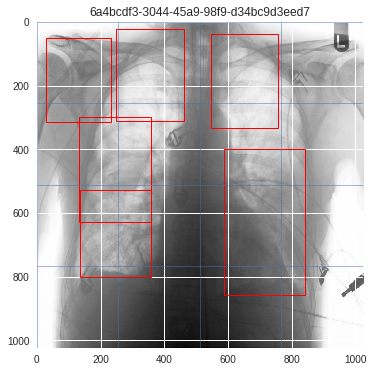

Truth: 1 1 306 228 156 282
Truth: 1 2 634 354 163 234
Pred: 0 0 conf: 0.90545446 8 41 207 265
Pred: 0 1 conf: 0.9326649 270 42 209 272
Pred: 0 2 conf: 0.8558133 540 52 205 253
Pred: 1 1 conf: 0.9999999 212 213 228 350
Pred: 1 2 conf: 0.99999917 596 258 245 414
Pred: 2 1 conf: 0.71787995 202 433 218 283
Pred: 2 2 conf: 0.9983752 587 465 231 337
True: 82134 Pred: 382909 Intersect: 80031
IOU: 0.20786624832418765


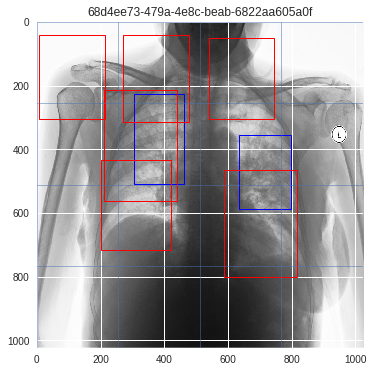

Pred: 0 0 conf: 0.79970396 25 51 205 248
Pred: 0 1 conf: 0.874744 262 49 206 249
Pred: 0 2 conf: 0.8796952 537 49 204 251
Pred: 3 0 conf: 0.7403401 129 810 219 268
True: 0 Pred: 212030 Intersect: 0
IOU: 0.0


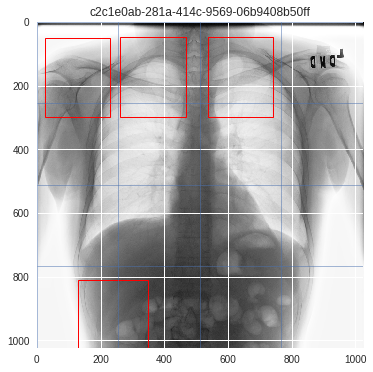

Pred: 0 0 conf: 0.8638245 17 45 205 266
Pred: 0 1 conf: 0.93315303 260 42 208 258
Pred: 0 2 conf: 0.93967915 527 43 205 256
Pred: 2 0 conf: 0.75108445 128 527 220 269
True: 0 Pred: 219854 Intersect: 0
IOU: 0.0


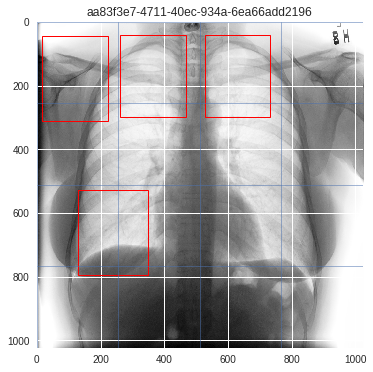

Pred: 0 0 conf: 0.89472556 18 48 208 260
Pred: 0 1 conf: 0.9520059 277 44 208 276
Pred: 0 2 conf: 0.94203204 531 43 208 270
Pred: 1 1 conf: 0.9999981 263 250 229 317
Pred: 1 3 conf: 0.99195707 667 147 262 415
Pred: 2 1 conf: 0.72326636 238 464 211 252
Pred: 2 3 conf: 0.8440039 669 415 242 302
True: 0 Pred: 475227 Intersect: 0
IOU: 0.0


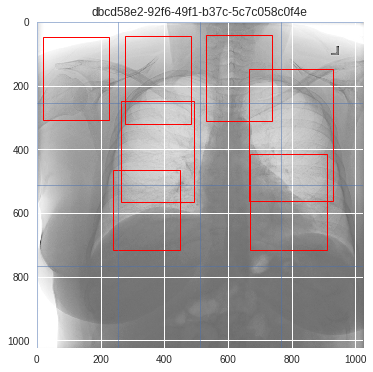

Truth: 2 1 180 504 242 201
Truth: 2 2 614 527 272 175
Pred: 0 0 conf: 0.9491338 11 41 208 272
Pred: 0 1 conf: 0.9442453 266 45 208 253
Pred: 0 2 conf: 0.9162323 544 46 207 265
Pred: 1 1 conf: 0.97513855 161 156 257 398
Pred: 1 2 conf: 0.76269966 614 277 235 356
Pred: 2 0 conf: 0.86781216 129 544 219 270
Pred: 2 1 conf: 0.9224558 219 476 204 227
Pred: 2 2 conf: 0.7680713 581 501 219 285
Pred: 2 3 conf: 0.8087605 671 422 237 279
True: 96242 Pred: 401385 Intersect: 108908
IOU: 0.28017153779393295


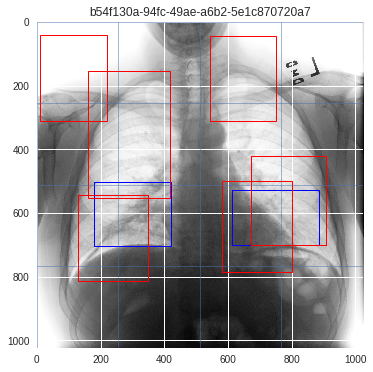

Overall Mean IOU: 0.1671584436880506


In [35]:
THRESHOLD = 0.7
OVERLAP = 0.4
NMS = True
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=15, replace=False)
# samples = problem_names

coords = np.arange(0, 1024, CELL_SIZE)
overall_ious = []

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # initialize our lists
    ious = []
    truths = []
    boxes = []
    
    # draw the truth boxes
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename].copy()
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    locs[i,j,:] = [1, x, y, w, h]
                    print("Truth:", i, j, x, y, w, h)
                    truths.append([x, y, w, h])
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    yhat = sigmoid(yhat)
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]    
    pred_boxes = np.zeros_like(bboxes)
#     print(conf)

    # loop through our predictions
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                print("Pred:", i, j, "conf:", conf_, x, y, w, h)
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h])
                
    # do non-max suppression of our boxes
    if NMS:
        nms_boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
    else:
        nms_boxes = boxes
    
    # plot our boxes
    for box in nms_boxes:
        x,y,w,h = box
        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    ## calculate the IOU
    true_area = 0
    # get the area of the true boxes
    for true_box in truths:
        x, y, w, h = true_box
        area = w * h
        true_area += area
        
    pred_area = 0
    # get the area of the predictions
    for pred_box in nms_boxes:
        x, y, w, h = pred_box
        area = w * h
        pred_area += area
        
    overall_intersect_area = 0
    # get the IOU by checking all combinations of boxes
    for true_box in truths:
        x1_t, y1_t, w_t, h_t = true_box
        for pred_box in nms_boxes:
            x1_p, y1_p, w_p, h_p = pred_box
            
            # get the far corners
            x2_p, y2_p = x1_p + w_p, y1_p + h_p
            x2_t, y2_t = x1_t + w_t, y1_t + h_t
        
            # get corners of intersection
            x1_i = np.maximum(x1_p, x1_t)
            y1_i = np.maximum(y1_p, y1_t)
            x2_i = np.minimum(x2_p, x2_t)
            y2_i = np.minimum(y2_p, y2_t)

            # get area of intersect
            i_w, i_h = x2_i - x1_i, y2_i - y1_i
            
            # trap for negative numbers
            i_w = np.maximum(i_w, 0)
            i_h = np.maximum(i_h, 0)
            
            intersect_area = i_w * i_h
            overall_intersect_area += intersect_area
            
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
    
    print("True:", true_area, "Pred:", pred_area, "Intersect:", overall_intersect_area)
    union_area = true_area + pred_area - overall_intersect_area
    
    iou = overall_intersect_area / (union_area + 1e-6)
    print("IOU:", iou)
    
    overall_ious.append(iou)
    plt.title(filename)
    plt.show()
    
print("Overall Mean IOU:", np.mean(overall_ious))    

# Predict test images

In [47]:
THRESHOLD = 0.75

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=24, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    yhats = model.predict(imgs)
    
    # apply sigmoid
    yhats = sigmoid(yhats)
    
    # loop through batch
    for yhat, filename in zip(yhats, filenames):
        predictionString = ""
        boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                conf = yhat[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = yhat[i,j, 1:]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(0.9) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

n test samples: 1000


In [49]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_file} -m "YOLOv17 512x512 60 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [34]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./yolo17_2_512.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/57.7 MiB.                                     
